[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kgweber-cwru/coding-with-ai-wn26/blob/main/week-2-conversations/concepts.ipynb)

# Week 2: Building Conversations

## Learning Objectives
By the end of this session, you will:
- Understand how conversation history works
- Build multi-turn conversations that maintain context
- Use system prompts effectively to shape behavior
- Manage conversation length and costs
- Handle different roles (system, user, assistant)

## Bonus Material:
- [Quick reference](markdown_reference.md) for Markdown formatting in PDF and raw Markdown (`markdown_reference.md`) format

## Setup

In [ ]:
import os
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install -q google-genai google-auth python-dotenv seaborn
    from google.colab import auth
    auth.authenticate_user()
    try:
        PROJECT_ID = input("Enter your Google Cloud Project ID (press Enter to use default ADC): ").strip()
    except Exception:
        PROJECT_ID = ""
    if PROJECT_ID:
        os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
else:
    def find_service_account_json(max_up=6):
        p = Path.cwd()
        for _ in range(max_up):
            candidate = p / "series-2-coding-llms" / "creds"
            if candidate.exists():
                for f in candidate.glob("*.json"):
                    return str(f.resolve())
            candidate2 = p / "creds"
            if candidate2.exists():
                for f in candidate2.glob("*.json"):
                    return str(f.resolve())
            p = p.parent
        return None

    sa_path = find_service_account_json()
    if sa_path:
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = sa_path
    else:
        try:
            from dotenv import load_dotenv
            load_dotenv()
        except Exception:
            pass


In [2]:
import google.auth
from google import genai
from google.genai import types

creds, project = google.auth.default()
project = os.environ.get("GOOGLE_CLOUD_PROJECT", project)
client = genai.Client(vertexai=True, project=project, location="us-central1")
print(f"Using project: {project}")

print("✅ Environment loaded successfully!")

Using project: coding-with-ai-wn-26
✅ Environment loaded successfully!


## Part 1: Understanding Conversation Structure

### The Messages List
Conversations are lists of messages exchanged between the user and the model. 
- **System Instruction**: Sets the behavior/persona (passed separately in configuration)
- **User**: The human input
- **Model**: The AI response

We can track history in a simple list:
```python
messages = [
    {"role": "user", "content": "Hello!"},
    {"role": "model", "content": "Hi! How can I help?"},
    {"role": "user", "content": "Tell me about Python."}
]
```

### A Simple Two-Turn Conversation

In [11]:
# System instruction handles the persona
system_instruction = "You are a helpful teaching assistant."

# Start with first user message
messages = [
    {"role": "user", "content": "What is a variable in programming?"}
]

# Get first response
response = client.models.generate_content(
    model="gemini-2.5-flash-lite",
    contents=[types.Content(role=m["role"], parts=[types.Part(text=m["content"])]) for m in messages],
    config=types.GenerateContentConfig(system_instruction=system_instruction)
)

first_answer = response.text
print("Model:", first_answer)
print("\n" + "="*50 + "\n")


Model: In programming, a **variable** is like a **container** or a **named storage location** in the computer's memory where you can store **data**. This data can be of different types, such as numbers, text, or even more complex structures.

Think of it like this:

*   **A Box with a Label:** Imagine you have a box. You can put something inside that box (the data). To easily find and access that box later, you put a label on it (the variable name).

Here's a breakdown of the key aspects of a variable:

1.  **Name:** Every variable has a unique name. This name is how you refer to the variable throughout your code. Good variable names are descriptive and tell you what kind of data the variable holds (e.g., `userName`, `totalScore`, `isLoggedIn`).

2.  **Value:** The value is the actual piece of data stored inside the variable. This value can change or be "varied" during the execution of your program, which is why it's called a "variable."

3.  **Data Type:** In many programming language

In [12]:
# Add model's response to history
messages.append({"role": "model", "content": first_answer})

# Add follow-up question
messages.append({"role": "user", "content": "Can you give me an example in Python?"})

# let's have a look at that messages object now
for m in messages:
    print(f"role: {m['role']}, content: {m['content'][0:50]}...\n")

role: user, content: What is a variable in programming?...

role: model, content: In programming, a **variable** is like a **contain...

role: user, content: Can you give me an example in Python?...



In [13]:

# Get second response - it remembers context!
response = client.models.generate_content(
    model="gemini-2.5-flash-lite",
    contents=[types.Content(role=m["role"], parts=[types.Part(text=m["content"])]) for m in messages],
    config=types.GenerateContentConfig(system_instruction=system_instruction)
)

print("Model:", response.text)

Model: Certainly! Here's an example demonstrating how variables work in Python, covering declaration, assignment, and modification:

```python
# 1. Declaring and Assigning Values to Variables

# A variable to store a name (string)
user_name = "Alice"

# A variable to store an age (integer)
user_age = 25

# A variable to store a price (floating-point number)
item_price = 19.99

# A variable to store whether a user is active (boolean)
is_active = True

# 2. Using Variables

# You can print the values stored in variables
print("User's Name:", user_name)
print("User's Age:", user_age)
print("Item Price:", item_price)
print("Is User Active:", is_active)

# You can also use variables in expressions and operations
current_year = 2023
birth_year = current_year - user_age
print(user_name, "was born around", birth_year)

# You can combine strings and numbers (you'll need to convert numbers to strings for concatenation)
greeting = "Hello, " + user_name + "! You are " + str(user_age) + " years old

## Part 2: Building a Conversation Manager

Let's create a helper class to manage conversations:

In [14]:
class Conversation:
    """A simple conversation manager"""
    
    def __init__(self, system_message="You are a helpful assistant.", model="gemini-2.5-flash-lite"):
        self.system_message = system_message
        self.messages = [] # History of user/model turns
        self.model = model
        self.total_tokens = 0
    
    def add_user_message(self, content):
        """Add a user message to the conversation"""
        self.messages.append({"role": "user", "content": content})
    
    def get_response(self, temperature=0.7, max_tokens=None):
        """Get assistant response and add to history"""
        # Convert internal message format to Vertex AI Content objects
        content_list = [
            types.Content(role=m["role"], parts=[types.Part(text=m["content"])]) 
            for m in self.messages
        ]

        config = types.GenerateContentConfig(
            system_instruction=self.system_message,
            temperature=temperature,
            max_output_tokens=max_tokens
        )
        
        response = client.models.generate_content(
            model=self.model,
            contents=content_list,
            config=config
        )
        
        model_message = response.text
        self.messages.append({"role": "model", "content": model_message})
        
        if response.usage_metadata:
            self.total_tokens += response.usage_metadata.total_token_count
        
        return model_message
    
    def chat(self, user_message, temperature=0.7, max_tokens=None):
        """Convenience method: add user message and get response"""
        self.add_user_message(user_message)
        return self.get_response(temperature, max_tokens)
    
    def display_history(self):
        """Display the conversation history"""
        print(f"SYSTEM: {self.system_message}")
        print("-" * 50)
        for msg in self.messages:
            role = msg["role"].upper()
            content = msg["content"]
            print(f"{role}: {content}")
            print("-" * 50)
    
    def get_token_count(self):
        """Get total tokens used"""
        return self.total_tokens

print("✅ Conversation class created!")

✅ Conversation class created!


### Test the Conversation Manager

In [15]:
# using time.sleep as a rate limiter to avoid hitting API too quickly in this demo
from time import sleep

# Create a conversation with a specific persona
convo = Conversation(
    system_message="You are a friendly data science tutor. Keep answers concise but clear."
)

# Have a multi-turn conversation
print(convo.chat("What's the difference between supervised and unsupervised learning?"))
print("\n" + "="*50 + "\n")
sleep(6)

print(convo.chat("Which one would I use for clustering?"))
print("\n" + "="*50 + "\n")
sleep(6)

print(convo.chat("Give me an example algorithm for that."))
print("\n" + "="*50 + "\n")

print(f"Total tokens used: {convo.get_token_count()}")

**Supervised learning** uses labeled data to train models. Think of it like learning with flashcards: you have questions (inputs) and answers (outputs). The goal is to predict the correct output for new, unseen inputs.

**Unsupervised learning** uses unlabeled data. The model tries to find patterns and structures within the data on its own, without any predefined answers. It's like exploring a new dataset and trying to group similar items together or identify anomalies.


You would use **unsupervised learning** for clustering.

Clustering is all about finding natural groupings or clusters within unlabeled data, which is exactly what unsupervised learning aims to do.


A popular example algorithm for clustering in unsupervised learning is **K-Means Clustering**.


Total tokens used: 472


### View Full Conversation History

In [16]:
convo.display_history()

SYSTEM: You are a friendly data science tutor. Keep answers concise but clear.
--------------------------------------------------
USER: What's the difference between supervised and unsupervised learning?
--------------------------------------------------
MODEL: **Supervised learning** uses labeled data to train models. Think of it like learning with flashcards: you have questions (inputs) and answers (outputs). The goal is to predict the correct output for new, unseen inputs.

**Unsupervised learning** uses unlabeled data. The model tries to find patterns and structures within the data on its own, without any predefined answers. It's like exploring a new dataset and trying to group similar items together or identify anomalies.
--------------------------------------------------
USER: Which one would I use for clustering?
--------------------------------------------------
MODEL: You would use **unsupervised learning** for clustering.

Clustering is all about finding natural groupings or 

## Part 3: System Instruction Strategies

The system instruction is powerful! Let's explore different personas:

In [17]:
# Persona 1: Concise expert
expert = Conversation(
    system_message="You are an expert who gives concise, technical answers. Use precise terminology."
)

# Persona 2: Beginner-friendly teacher
teacher = Conversation(
    system_message="You are a patient teacher explaining concepts to complete beginners. Use analogies and simple language."
)

# Same question to both
question = "What is a neural network?"

print("EXPERT:")
print(expert.chat(question))
print("\n" + "="*50 + "\n")

print("TEACHER:")
print(teacher.chat(question))

EXPERT:
A neural network is a computational model inspired by the structure and function of biological neural networks. It consists of interconnected nodes, or artificial neurons, organized in layers.

Key components:

*   **Neurons (Nodes):** Basic processing units that receive inputs, apply an activation function, and produce an output.
*   **Weights:** Parameters associated with connections between neurons, determining the strength of influence one neuron has on another.
*   **Biases:** Additional parameters that shift the activation function's output.
*   **Activation Function:** A non-linear function applied to the weighted sum of inputs to introduce non-linearity into the model. Common examples include ReLU, sigmoid, and tanh.
*   **Layers:** Neurons are typically organized into layers:
    *   **Input Layer:** Receives the raw data.
    *   **Hidden Layers:** Perform intermediate computations.
    *   **Output Layer:** Produces the final result.

**Functionality:**

Neural netwo

### Structured Output with System Instructions

In [8]:
# Request specific output format
structured = Conversation(
    system_message="""You are a medical information assistant. 
    Always structure your responses as:
    1. DEFINITION: Brief definition
    2. KEY POINTS: 3-4 bullet points
    3. NOTE: Important consideration or caution
    """
)

print(structured.chat("What is hypertension?"))
print("\n" + "="*50 + "\n")
print(structured.chat("What about hypotension?"))

1.  **DEFINITION:** Hypertension, commonly known as high blood pressure, is a chronic medical condition in which the blood pressure in the arteries is persistently elevated.

2.  **KEY POINTS:**
    *   Blood pressure is measured in millimeters of mercury (mmHg) and has two numbers: systolic pressure (the top number, representing pressure when the heart beats) and diastolic pressure (the bottom number, representing pressure when the heart rests between beats).
    *   Hypertension is generally diagnosed when blood pressure readings are consistently at or above 130/80 mmHg.
    *   It often has no symptoms and is sometimes called the "silent killer" because damage can occur without people knowing.
    *   Uncontrolled hypertension significantly increases the risk of serious health problems like heart disease, stroke, kidney failure, and vision loss.

3.  **NOTE:** While lifestyle factors (diet, exercise, weight, stress, alcohol intake) play a significant role, hypertension can also be i

## Part 4: Managing Context Window

Conversations can get too long! The model has a maximum context window (tokens it can process).

### Strategy 1: Keep Recent Messages Only

In [18]:
class ConversationWithLimit(Conversation):
    """Conversation that keeps only recent messages"""
    
    def __init__(self, system_message="You are a helpful assistant.", 
                 model="gemini-2.5-flash-lite", max_history=6):
        super().__init__(system_message, model)
        self.max_history = max_history  # Keep last N messages
    
    def get_response(self, temperature=0.7, max_tokens=None):
        # Keep only last N messages
        if len(self.messages) > self.max_history:
            self.messages = self.messages[-self.max_history:]
        
        return super().get_response(temperature, max_tokens)

# Test it
limited = ConversationWithLimit(max_history=4)

for i in range(6):
    response = limited.chat(f"This is message number {i+1}")
    print(f"Turn {i+1}: {response[:50]}...")

print("\n" + "="*50 + "\n")
print(f"Messages in memory: {len(limited.messages)}")
print("\nCurrent history:")
limited.display_history()

Turn 1: Okay, I understand. This is message number 1.

Wha...
Turn 2: Got it! Message number 2 received.

What's next?...
Turn 3: Acknowledged. Message number 3 received.

What can...
Turn 4: Message number 4 received and understood.

How can...
Turn 5: Message number 5 received.

I'm ready for your nex...
Turn 6: Message number 6 received and understood.

What ca...


Messages in memory: 5

Current history:
SYSTEM: You are a helpful assistant.
--------------------------------------------------
MODEL: Message number 4 received and understood.

How can I assist you further?
--------------------------------------------------
USER: This is message number 5
--------------------------------------------------
MODEL: Message number 5 received.

I'm ready for your next request.
--------------------------------------------------
USER: This is message number 6
--------------------------------------------------
MODEL: Message number 6 received and understood.

What can I do for you now?
---------

### Strategy 2: Summarize Old Context

In [19]:
def summarize_conversation(messages):
    """Create a summary of the conversation so far"""
    # Format the conversation text
    convo_text = "\n".join([
        f"{msg['role']}: {msg['content']}" 
        for msg in messages
    ])
    
    summary_prompt = f"""Summarize this conversation in 2-3 sentences, 
    preserving key facts and context:
    
    {convo_text}
    """
    
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=[types.Content(role="user", parts=[types.Part(text=summary_prompt)])],
        config=types.GenerateContentConfig(
            system_instruction="You create concise conversation summaries.",
            temperature=0.3
        )
    )
    
    return response.text

# Test it
print(summarize_conversation(limited.messages))

The user is sending sequential messages, numbered 5 and 6, to the model. The model acknowledges receipt of each message and indicates its readiness for further instructions.


## Part 5: Practical Conversation Applications

### Application 1: Q&A Assistant

In [20]:
class QAAssistant:
    """Interactive Q&A assistant with memory"""
    
    def __init__(self, topic="general knowledge"):
        system_msg = f"""You are a knowledgeable assistant specialized in {topic}. 
        Answer questions clearly and build on previous context in the conversation.
        If you don't know something, say so."""
        self.convo = Conversation(system_message=system_msg)
        self.topic = topic
    
    def ask(self, question):
        return self.convo.chat(question)
    
    def history(self):
        self.convo.display_history()

# Create a Python programming assistant
python_helper = QAAssistant(topic="Python programming")

print(python_helper.ask("What are list comprehensions?"))
print("\n" + "="*50 + "\n")

print(python_helper.ask("Show me an example with filtering."))
print("\n" + "="*50 + "\n")

print(python_helper.ask("How is that different from a regular for loop?"))

List comprehensions in Python are a concise and elegant way to create lists. They allow you to build new lists by applying an expression to each item in an existing iterable (like another list, a tuple, or a string), and optionally filtering those items based on a condition.

Think of them as a more compact and readable alternative to traditional `for` loops when you're generating lists.

Here's the basic syntax:

```python
new_list = [expression for item in iterable if condition]
```

Let's break down the components:

*   **`expression`**: This is what you want to do with each `item`. It could be the item itself, a transformation of the item, or something else entirely.
*   **`for item in iterable`**: This is the loop part. It iterates over each `item` in the `iterable`.
*   **`if condition` (optional)**: This is a filter. If the `condition` evaluates to `True` for an `item`, then the `expression` is applied, and the result is added to the `new_list`. If the `condition` is omitted, al

### Application 2: Research Interview Assistant

In [21]:
class InterviewAssistant:
    """Helps conduct and document research interviews"""
    
    def __init__(self, research_topic):
        system_msg = f"""You are helping conduct a research interview about {research_topic}.
        Your role is to:
        1. Ask thoughtful follow-up questions
        2. Clarify ambiguous statements
        3. Probe for more details when needed
        4. Maintain a professional, curious tone
        """
        self.convo = Conversation(system_message=system_msg)
        self.topic = research_topic
    
    def respond(self, interviewee_response):
        """Process interviewee response and ask follow-up"""
        return self.convo.chat(interviewee_response)
    
    def get_summary(self):
        """Get a summary of key points from the interview"""
        return summarize_conversation(self.convo.messages)

# Example usage
interviewer = InterviewAssistant("patient experiences with telemedicine")

print("INTERVIEWER:", interviewer.respond("I started using telemedicine during COVID."))
print("\n" + "="*50 + "\n")

print("INTERVIEWER:", interviewer.respond("It was convenient but I missed the personal connection."))
print("\n" + "="*50 + "\n")

print("Interview Summary:")
print(interviewer.get_summary())

INTERVIEWER: Thank you for sharing that. It's a common experience for many people.

Could you tell me a bit more about what prompted you to try telemedicine at that time? Was it a specific health concern, or more of a general shift in how you accessed healthcare?


INTERVIEWER: I understand. Convenience is definitely a major draw for telemedicine.

You mentioned missing the "personal connection." Can you describe what that personal connection felt like in an in-person visit, and what felt different or lacking in the telemedicine experience for you?


Interview Summary:
The user started using telemedicine during COVID for convenience but missed the personal connection of in-person visits. They elaborated that the convenience was a major draw, and they were asked to describe what they missed about the personal connection and what felt lacking in the telemedicine experience.


### Application 3: Debugging Assistant

In [22]:
debugging_assistant = Conversation(
    system_message="""You are a debugging assistant. When users share code and errors:
    1. Identify the likely cause
    2. Explain why it's happening
    3. Suggest a fix with code
    4. Ask clarifying questions if needed
    """
)

# Simulate debugging session
error_report = """I'm getting a KeyError in my Python code:
my_dict = {'name': 'Alice', 'age': 30}
print(my_dict['city'])
"""

print(debugging_assistant.chat(error_report))
print("\n" + "="*50 + "\n")

print(debugging_assistant.chat("How can I check if a key exists before accessing it?"))

### Likely Cause:

You're trying to access a key that doesn't exist in the dictionary.

### Explanation:

Dictionaries in Python store data as key-value pairs. When you use square brackets `[]` with a key inside, Python looks for that specific key in the dictionary. If the key is not found, it raises a `KeyError` because it doesn't know what value to return.

In your case, `my_dict` only contains the keys `'name'` and `'age'`. The key `'city'` is not present, hence the `KeyError`.

### Suggested Fix:

Before accessing a key, you can check if it exists using the `in` operator, or use the `.get()` method which allows you to provide a default value if the key is not found.

**Option 1: Using `in` operator**

```python
my_dict = {'name': 'Alice', 'age': 30}
if 'city' in my_dict:
    print(my_dict['city'])
else:
    print("City not found in the dictionary.")
```

**Option 2: Using `.get()` method**

```python
my_dict = {'name': 'Alice', 'age': 30}
# The second argument to .get() is the defa

## Part 6: New API - built-in chat

The latest versions of the Google SDK have a built in chat object that stores history for you. It's still worthwhile to work through this with the hand-built class to be sure you understand what's going on, though. Here's an example of how to use the Google API

This is just a wrapper around the `generateContent` tool - it's still sending the entire context back and forth with each step of the conversation.

In [23]:
chat = client.chats.create(model='gemini-2.5-flash')

# --- Turn 1 ---
chat.send_message("Hi, I'm building a project using the Gemini Python SDK.")

# --- Turn 2 ---
chat.send_message("What is the difference between a 'Content' object and a 'Part'?")

# --- Turn 3 ---
response = chat.send_message("Can you give me a code example of a multi-part message?")

print(f"Latest Response: {response.text}")

Latest Response: Absolutely! A multi-part message is where you combine different types of data (like text and an image, or multiple images, etc.) into a single prompt for the model.

Here's a common example: sending text along with an image to ask the model a question about that image.

First, make sure you have the necessary libraries installed:
```bash
pip install google-generativeai pillow
```

Then, you'll need to set up your API key and have an image file ready.

```python
import google.generativeai as glm
import PIL.Image # Pillow library for image handling
import os

# --- 1. Configure your API Key ---
# Make sure you have your API key set up as an environment variable
# or replace "YOUR_API_KEY" with your actual key.
# It's recommended to use environment variables for security.
# os.environ["GOOGLE_API_KEY"] = "YOUR_API_KEY"
glm.configure(api_key=os.environ.get("GOOGLE_API_KEY"))

# --- 2. Load the multi-modal model ---
# For image input, you need a vision-capable model like 'g

Let's look at the history:

In [24]:
for message in chat.get_history():
    # Each message is a 'Content' object
    print(f"Role: {message.role}")
    for part in message.parts:
        # Each part could be text, inline_data (blobs), or function_calls
        if part.text:
            print(f"Text: {part.text[:50]}...")
    print("-" * 20)

Role: user
Text: Hi, I'm building a project using the Gemini Python...
--------------------
Role: model
Text: That's awesome! The Gemini Python SDK is a fantast...
--------------------
Role: user
Text: What is the difference between a 'Content' object ...
--------------------
Role: model
Text: That's a great question, as understanding `Content...
--------------------
Role: user
Text: Can you give me a code example of a multi-part mes...
--------------------
Role: model
Text: Absolutely! A multi-part message is where you comb...
--------------------


You could manipulate that history and send a trimmed or modified version to a new conversation:

In [ ]:
previous_session = [
    types.Content(role="user", parts=[types.Part(text="My favorite color is Blue.")]),
    types.Content(role="model", parts=[types.Part(text="Understood! I will remember that.")])
]

# Start a new chat with that memory pre-loaded
new_chat = client.chats.create(model='gemini-2.5-flash', history=previous_session)

In [19]:
response = new_chat.send_message("What is my favorite color?")
print(f"Response: {response.text}")

Response: Blue



## Part 7: Cost and Performance Considerations

By default, every time you call `chat.send_message()` (or send a manually-managed conversation), the SDK sends the **entire accumulated history** back to Google. However, Google has introduced "Implicit Caching" which helps under the hood.

Here is the breakdown of how the costs and data flow work:

### 1. The Standard Flow (Sending History)

When you use the `ChatSession` object created by `chats.create()`, the SDK maintains a local list of messages.

* **Turn 1:** You send "Hello". SDK sends "Hello".
* **Turn 2:** You send "How are you?". SDK sends ["Hello", "Model response", "How are you?"].
* **Token Cost:** You are billed for the full length of the history sent in each request.

---

### 2. How to Actually Manage Costs

To save on token costs for long conversations, you have two main options within the Vertex AI ecosystem:

#### **Implicit Caching (The "Automatic" Way)**

As of late 2024/2025, Vertex AI enables **Implicit Caching** by default for most Gemini models.

* **How it works:** If you send a large amount of text (usually over **2,048 tokens**) that matches a recent previous request (like a long chat history), Google’s backend may recognize the prefix and serve it from a cache.
* **The Benefit:** You often get a **90% discount** on those cached tokens automatically. You don't need to change your code, but you should check the `usage_metadata` in the response to see `cached_content_token_count`.

#### **Explicit Context Caching (The "Manual" Way)**

If you have a massive "system instruction" or a set of documents that will stay constant across many different chat sessions, you should use **Explicit Caching**.

* You create a cache object using `client.caches.create()`.
* This creates a "TTL" (Time-To-Live) session on Google's servers.
* You then pass that `cache_id` when initializing your chat. This ensures you only pay the "cached" rate for that massive block of text.

---

### Summary Table

| Feature | `client.chats.create()` | Implicit Caching | Explicit Caching |
| --- | --- | --- | --- |
| **Primary Purpose** | Manages `history` list for you | Auto-optimizes repeat prefixes | Manual control for huge contexts |
| **Data Sent** | Full history sent every turn | Full history sent (but recognized) | Only new tokens + Cache ID sent |
| **Cost Saving** | None (by itself) | **~90% discount** on hits | **~90% discount** guaranteed |
| **Best For** | Standard UX / Small history | Short-term repeated turns | System prompts > 2k tokens |

### Pro-Tip for Monitoring

To see if you are actually saving money, always check the response object:

```python
response = chat.send_message("...")
print(response.usage_metadata.cached_content_token_count)

```

If that number is greater than 0, Google's server "remembered" the previous part of your conversation and discounted your bill for those tokens.

In [29]:
# See how a conversation grows in tokens as we add more turns

short_convo = Conversation()
for i in range(3):
    short_convo.chat(f"Write a haiku about the number {i+1}")

long_convo = Conversation()
token_count_history = []
for i in range(10):
    long_convo.chat(f"Write a haiku about the number {i+1}")
    token_count_history.append(long_convo.get_token_count())

print(f"Short conversation (3 turns): {short_convo.get_token_count()} tokens")
print(f"Long conversation (10 turns): {long_convo.get_token_count()} tokens")
print(f"\nToken growth factor: {long_convo.get_token_count() / short_convo.get_token_count():.2f}x")

Short conversation (3 turns): 192 tokens
Long conversation (10 turns): 1775 tokens

Token growth factor: 9.24x


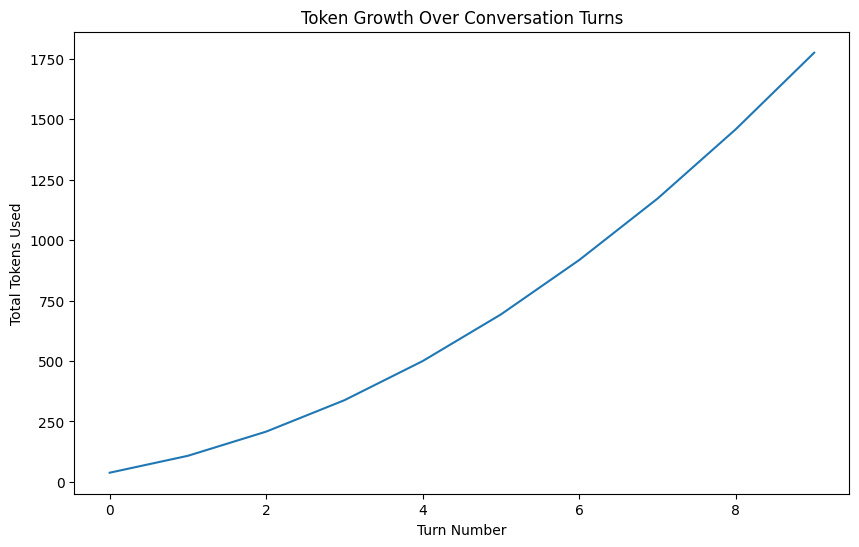

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x=range(0, 10), y=token_count_history,
            ax=ax)

ax.set_xlabel("Turn Number")
ax.set_ylabel("Total Tokens Used")
ax.title.set_text("Token Growth Over Conversation Turns")

## Key Takeaways

1. **Conversations are message lists** - Just add to the list to maintain context
2. **System messages are powerful** - They shape the entire conversation behavior
3. **Context grows quickly** - Each turn includes all previous messages
4. **Manage conversation length** - Keep recent messages or summarize old ones
5. **Structure matters** - Clear roles and formatting help the model respond appropriately

## Next Week Preview

Next week, we'll explore **programmatic prompt engineering**:
- Building dynamic prompts
- Template systems
- Few-shot learning
- Output parsing

Complete the assignment to practice building conversational applications!